Date Created: 09/25/20
## Goal of Notebook: Analyze Differences in Gene Identifiers: Pham & Function

This notion of pham as a subset of function is an important relationship that we could utilize in future genome generation. For example if pham is a subset then you could imagine that we generate a genome but by functional components then to get actual protien sequences we could generate functionally compatible phams. It makes sense that certain genes need to interface with each other. For structural reasons minor tail protiens and the head to tail connector. For host compatibility like if we need specific holin and lysin to integrate with the specific hosts cell wall.


### High Level Questions:

#### Annotation Error Propagation (this is relatively unrelated to the task at hand)
To what extent is error being propigated through the annotation network? If a genome is annotated inncorrectly will the next genome that is similar grab that error? Anotation of one genome is dependent on current annotated genomes. If a gene is annotated how likely is it to take on the same info as previously annotated genes. Does unique spelling errors show independent thought, likewise, does non-unique misspelled annotations show dependence.

#### Evolution or Functionality?
As shown in the analysis below phams are very specific to cluster. That being said does that mean a gene from one cluster will not be functionally compatible in a genome from another cluster? Or is this because of evolutionary lineage that presents itself in statistical correlation?


In [38]:
# import libraries
import requests 
import pandas as pd
from random import sample 
import matplotlib
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns                                                             
import sys
import scipy

### Load in the data

In [39]:
df_genes = pd.read_csv("data/gene_metadata.csv")
df_genes.head()

,gene ID,pham,function,translation,orientation,phage,gene number,start,stop,uncleaned function
0,20ES_CDS_1,36676,NKF,MYGTRSSAFWASQPGKFDVLNLRMTFPSTSAHEIPDLTATDFVPEN...,F,20ES,1,568,1336,NaN
1,20ES_CDS_10,39578,lysin b,MSLQVGSSGELVNRWIRVMKARFASYAGKLKEDGYFGLDDKAVQQE...,F,20ES,10,6442,7420,lysin b
2,20ES_CDS_11,34196,terminase,MSLENHHPELAPSPPHIIGPSWQRTVDGSWHLPDPKMTLGWGVLKW...,F,20ES,11,7442,9233,terminase
3,20ES_CDS_12,39511,portal protein,MTAPLPGQEEIPDPAIARDEMISAFDDAVKNLKINTSYYEAERRPE...,F,20ES,12,9229,10690,portal protein
4,20ES_CDS_13,21454,capsid maturation protease,MITAAVAAYVQRFASMFTGPALSLGEWARFLQTLFPEVQRRYAQAA...,F,20ES,13,10719,11583,capsid maturation protease


In [40]:
df_phages = pd.read_csv("data/phage_metadata.csv")
df_phages.head()

,phage,temperate,cluster,subcluster,morphotype,host genus,host species,genome length,is annotated,is phamerated,gcpercent
0,20ES,True,A,A2,SIPHO,Mycobacterium,smegmatis,53124,False,True,63.4
1,244,True,E,NaN,SIPHO,Mycobacterium,smegmatis,74483,True,True,63.4
2,32HC,True,Z,NaN,SIPHO,Mycobacterium,smegmatis,50781,False,True,65.7
3,39HC,False,B,B6,SIPHO,Mycobacterium,smegmatis,71565,False,True,70.0
4,40AC,True,A,A17,SIPHO,Mycobacterium,smegmatis,53396,False,True,63.3


### Gene Content Similairity 
- The number of shared phams between two genomes (based on PhagesDB def)

This metric was made becuase current clustering is whole genome nucleotide similairity, however, not every nucleotide has the same impact on the phage's function.

For example: Burton (A1) 27% GCS with Phlei (A13)

In [44]:
a = "Burton"
b = "Phlei"

In [45]:
df_a = df_genes[df_genes["phage"]==a][["gene ID","pham"]]
df_a.head()

,gene ID,pham


In [43]:
df_b = df_genes[df_genes["phage"]==b][["gene ID","pham"]]
df_b.head()

,gene ID,pham
221812,Phlei_CDS_1,36593
221813,Phlei_CDS_10,21454
221814,Phlei_CDS_11,8023
221815,Phlei_CDS_12,15229
221816,Phlei_CDS_13,39449


In [37]:
print("Gene Content Similarity (% shared phams) {} and {}:".format(a,b))
phams_a = list(sorted(df_a["pham"]))
phams_b = list(sorted(df_b["pham"]))
shared_phams = []
for i in phams_a:
    if i in phams_b:
        shared_phams.append(i)

print(100*2*len(shared_phams)/(len(phams_b)+len(phams_a)))

Gene Content Similarity (% shared phams) Burton and Phlei:
0.0


### Construct a Bipartite Graph: Pham <-> Function
- Edge: if a gene has pham i and function j then edge i->j represents this observance
- Node: either a function or a pham

This representation can help us understand whether pham is a subset of function. Alternatively a pham could contain multiple functions. Based on this we can better understand the relationship between pham and function.

In [30]:
G = nx.Graph()
for index, row in df_genes.iterrows():
    phage = row["phage"]
    function = row['uncleaned function'] #this notebook was originally created with unclean function data
    pham = row['pham']
    if not df_phages[df_phages["phage"] == phage].empty:
        subcluster = df_phages[df_phages["phage"] == phage]["subcluster"].values[0]
        cluster = df_phages[df_phages["phage"] == phage]["cluster"].values[0]
        # ADD PHAM NODE iF it doesn't exist
        if not G.has_node(pham):
            G.add_node(pham, group='pham', clusters=[cluster], subclusters=[subcluster], phages=[phage], freq = 1)
        else:
            G.nodes[pham]["freq"] += 1
            G.nodes[pham]["clusters"].append(cluster)
            G.nodes[pham]["subclusters"].append(subcluster)
            G.nodes[pham]["phages"].append(phage)

        # ADD FUNCTION NODE if it doesn't exist
        if not G.has_node(function):
            G.add_node(function, group='function', clusters=[cluster], subclusters=[subcluster], phages=[phage], freq = 1)
        else:
            G.nodes[function]["freq"] += 1
            G.nodes[function]["clusters"].append(cluster)
            G.nodes[function]["subclusters"].append(subcluster)
            G.nodes[function]["phages"].append(phage)

        # ADD EDGE if it doesn't exist or increase weight     
        if G.has_edge(pham, function):
            G.edges[pham, function]["weight"] += 1  
        else:
            G.add_edge(pham, function, weight = 1)
        

In [26]:
nx.write_gml(G,"networks/bipartite_pham_uncleaned_func.gml")

NetworkXError: 0    A
Name: cluster, dtype: object is not a string

### Lets validate the graph was made correctly

In [17]:
function_count = 0
pham_count = 0

for i in G.nodes():
    if G.nodes[i]["group"] == "function":
        function_count += 1
    else:
        pham_count += 1
        
print("Pham count from Network:", pham_count, "--- Actual Count from df:",df_genes["pham"].nunique())
print("Function count from Network:", function_count, "--- Actual Count from df:",df_genes["uncleaned function"].nunique())

Pham count from Network: 22948 --- Actual Count from df: 23224
Function count from Network: 1631 --- Actual Count from df: 1668


In [15]:
n = G.number_of_nodes()#function for number of nodes
m = G.size() #function for number of edges
kmean = m*2/n #mean of in directed degree is edges/number of nodes

print(f'number of nodes, n  = {n}')
print(f'number of edges, m  = {m}')
print(f'mean degree,    <k> = %5.2f' % kmean)

number of nodes, n  = 24579
number of edges, m  = 29632
mean degree,    <k> =  2.41


In [16]:
kmean_function = m/function_count
kmean_pham = m/pham_count
print(f'mean degree for function,    <k> = %5.2f' % kmean_function)
print(f'mean degree for pham   <k> = %5.2f' % kmean_pham)

mean degree for function,    <k> = 18.17
mean degree for pham   <k> =  1.29


This means that most phams are only attached to 1 function, with exception. While must functions are attached to multiple phams, which makes sense for the hypothesis that pham is a subset of function. We also guess that all phams are connected to one function, but it appears as multiple due to mispellings.


#### Are the phams connected to multiple functions due to misspellings?

https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-12-395

Pham calculations

We conclude that inclusion of BLASTP contributes rather little to the pham assembly process, but that a combination of a CLUSTALW threshold of 32.5% and a BLASTP cut off of 10-50 offers optimal parameters for this dataset, building phams of homologous proteins while minimizing construction of complex phams in which only segments of the proteins are related to each other.

In [ ]:
for i in G.nodes():
    if G.nodes[i]["group"] == "pham" and len(list(G.neighbors(i)))>1:
        print("PHAM:", i)
        neighbors = list(G.neighbors(i))
        for ne in neighbors:
            print("\t Functions:", ne)

Looks like some are misspellings (ie pham 34072 lysin A, lysA, putative LysA), but some are niche protiens. Could we make a pseudo function for phams that all have NKF? 

Also sometimes it looks like (PHAM: 14988) minor tail protein, minor tail subunit, tape measure protein, major tail protein are all in the same Pham. Or 21865, head-to-tail terminator, head-to-tail adaptor, head-tail connector.

### What is the distribution of orphams?

In [ ]:
orpham_count = 0
for i in G.nodes():
    if G.nodes[i]["group"] == "pham" and len(G.nodes[i]["clusters"])>1:
        orpham_count += 1
print("orpham count: ", orpham_count)
# total count is 23216

### Are phams or functions present in mutiple distinct clusts?

###### Genes/Clusters per pham

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(12,10))

functions = sorted(list(df_genes["Pham"].unique()))
unique_cluster = []
for i in functions:
    unique_cluster.append(len(G.nodes[i]["clusters"]))

ax[0,0].hist(unique_cluster, bins=range(0,5000, 100), color = "pink")
ax[0,0].set_xlabel("# of genes (bin size = 100)")
ax[0,0].set_ylabel("Frequency")
ax[0,0].set_title("Histogram of genes per Pham")
ax[0,0].set_yscale('log')
print("\n Histogram of genes per Pham", scipy.stats.describe(unique_cluster))

functions = sorted(list(df_genes["Pham"].unique()))
unique_cluster = []
for i in functions:
    unique_cluster.append(len(np.unique(G.nodes[i]["clusters"])))
    
ax[0,1].hist(unique_cluster, bins=range(0,275,5))
ax[0,1].set_xlabel("# of unique clusters (bin size = 5)")
ax[0,1].set_ylabel("Frequency")
ax[0,1].set_title("Histogram of unique clusters per Pham")
ax[0,1].set_yscale('log')
print("\n Histogram of unique clusters per Pham", scipy.stats.describe(unique_cluster))


functions = sorted(list(df_genes["Pham"].unique()))
unique_cluster = []
for i in functions:
    unique_cluster.append(len(np.unique(G.nodes[i]["phages"])))

ax[1,0].hist(unique_cluster, bins=range(0,5000, 100), color = "green")
ax[1,0].set_xlabel("# phages (bin size = 100)")
ax[1,0].set_ylabel("Frequency")
ax[1,0].set_title("Histogram of phages per Pham")
ax[1,0].set_yscale('log')
print("\n Histogram of phages per Function", scipy.stats.describe(unique_cluster))

functions = sorted(list(df_genes["Pham"].unique()))
unique_cluster = []
for i in functions:
    unique_cluster.append(len(np.unique(G.nodes[i]["subclusters"])))
    
ax[1,1].hist(unique_cluster, bins=range(0,275,5), color = "orange")
ax[1,1].set_xlabel("# unique subclusters (bin size = 5)")
ax[1,1].set_ylabel("Frequency")
ax[1,1].set_title("Histogram of unique subclusters per Pham")
ax[1,1].set_yscale('log')
print("\n Histogram of unique subclusters per Pham", scipy.stats.describe(unique_cluster))


plt.show()

###### Genes/Clusters per Function

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(12,10))

functions = sorted(list(df_genes["Function"].unique()))
unique_cluster = []
for i in functions:
    unique_cluster.append(len(G.nodes[i]["clusters"]))

ax[0,0].hist(unique_cluster, bins=range(0,5000, 100), color = "pink")
ax[0,0].set_xlabel("# of genes (bin size = 100)")
ax[0,0].set_ylabel("Frequency")
ax[0,0].set_title("Histogram of genes per Function")
ax[0,0].set_yscale('log')
print("\n Histogram of genes per Function", scipy.stats.describe(unique_cluster))

functions = sorted(list(df_genes["Function"].unique()))
unique_cluster = []
for i in functions:
    unique_cluster.append(len(np.unique(G.nodes[i]["clusters"])))
    
ax[0,1].hist(unique_cluster, bins=range(0,275,5))
ax[0,1].set_xlabel("# of unique clusters (bin size = 5)")
ax[0,1].set_ylabel("Frequency")
ax[0,1].set_title("Histogram of unique clusters per Function")
ax[0,1].set_yscale('log')
print("\n Histogram of unique clusters per Function", scipy.stats.describe(unique_cluster))


functions = sorted(list(df_genes["Function"].unique()))
unique_cluster = []
for i in functions:
    unique_cluster.append(len(np.unique(G.nodes[i]["phages"])))

ax[1,0].hist(unique_cluster, bins=range(0,5000, 100), color = "green")
ax[1,0].set_xlabel("# phages (bin size = 100)")
ax[1,0].set_ylabel("Frequency")
ax[1,0].set_title("Histogram of phages per function")
ax[1,0].set_yscale('log')
print("\n Histogram of phages per Function", scipy.stats.describe(unique_cluster))

functions = sorted(list(df_genes["Function"].unique()))
unique_cluster = []
for i in functions:
    unique_cluster.append(len(np.unique(G.nodes[i]["subclusters"])))
    
ax[1,1].hist(unique_cluster, bins=range(0,275,5), color = "orange")
ax[1,1].set_xlabel("# unique subclusters (bin size = 5)")
ax[1,1].set_ylabel("Frequency")
ax[1,1].set_title("Histogram of unique subclusters per Function")
ax[1,1].set_yscale('log')
print("\n Histogram of unique subclusters per Function", scipy.stats.describe(unique_cluster))


plt.show()


In [ ]:
G.copy()


edge_cut_prop = np.linspace(0.01, 1.0, num=10)
true_ratio = []
false_ratio = []
true_count = []
false_count = []
total_count = []
for prop in edge_cut_prop:
    true = 0
    false = 0
    count = 0
    for i, j in G.edges():
        func = i if G.nodes[i]["group"] == "function" else j
        pham = i if G.nodes[i]["group"] == "pham" else j
        num_pham_members = G.nodes[pham]["freq"]
        if G.edges[i,j]["weight"]/num_pham_members < prop:
            if func.lower() in funcList:
                true += 1
            else:
                false += 1
            count += 1

    true_ratio += [true/count]
    false_ratio += [false/count]
    true_count += [true]
    false_count += [false]
    total_count += [count]

In [ ]:
n = G.number_of_nodes()#function for number of nodes
m = G.size() #function for number of edges
kmean = m*2/n #mean of in directed degree is edges/number of nodes

print(f'number of nodes, n  = {n}')
print(f'number of edges, m  = {m}')
print(f'mean degree,    <k> = %5.2f' % kmean)

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))

plt.plot(edge_cut_prop, false_ratio)

plt.fill_between(edge_cut_prop, false_ratio, [1]*len(edge_cut_prop),
                 facecolor="green", # The fill color
                 color='green',       # The outline color
                 alpha=0.2,          # Transparency of the fill
                 label = "Edges to approved functions")

plt.fill_between(edge_cut_prop, [0]*len(edge_cut_prop), false_ratio,
                 facecolor="red", # The fill color
                 color='red',       # The outline color
                 alpha=0.2,          # Transparency of the fill
                 label = "Edges to unapproved functions")


plt.ylabel("proportion")
plt.xlabel("proportion threshold to cut an edge")
plt.legend()


plt.title("Edge Cutting")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))

plt.plot(edge_cut_prop, false_count)

plt.fill_between(edge_cut_prop, false_count, total_count,
                 facecolor="green", # The fill color
                 color='green',       # The outline color
                 alpha=0.2,          # Transparency of the fill
                 label = "Edges to approved functions")

plt.fill_between(edge_cut_prop, [0]*len(edge_cut_prop), false_count,
                 facecolor="red", # The fill color
                 color='red',       # The outline color
                 alpha=0.2,          # Transparency of the fill
                 label = "Edges to unapproved functions")


plt.ylabel("count of cut edges")
plt.xlabel("proportion threshold to cut an edge (weight of edge(pham member of a func)/total number of pham members)")
plt.legend()

plt.title("Edge Cutting")
plt.show()

### Faulty Visualizations

In [17]:
cat = "Pham"
phams = sorted(list(df_genes[cat].unique()))
clusters = sorted(list(df_genes["Cluster"].unique()))

# empty array for results
a = [0]*df_genes["Cluster"].nunique()
pham_cluster = [a for _ in phams]

print(len(pham_cluster))
print(len(pham_cluster[0]))
#make a dict for clusters
for p in range(len(phams)):
    total = len(G.nodes[phams[p]]["clusters"])
    for c in range(len(clusters)):
        pham_cluster[p][c] = G.nodes[phams[p]]["clusters"].count(clusters[c])/total



23208
274


/Users/skymartin/opt/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:302: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  cmap=self.cmap, **kws)


<AxesSubplot:>

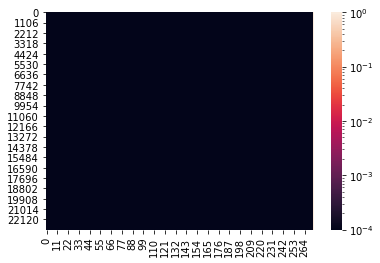

In [18]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import seaborn as sn
import matplotlib.colors as colors

import math
data =  np.array(pham_cluster) + 0.0001

log_norm = LogNorm(vmin=data.min().min(), vmax=data.max().max())
cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(data.min().min())), 1+math.ceil(math.log10(data.max().max())))]

sn.heatmap(
    data,
    norm=log_norm,
    cbar_kws={"ticks": cbar_ticks}
)

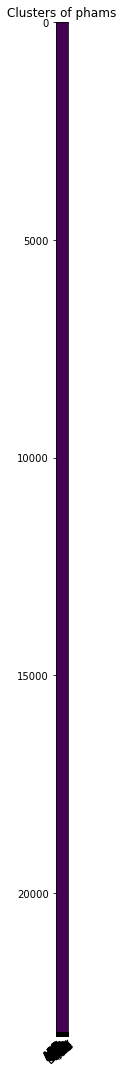

In [19]:
fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(pham_cluster)

# We want to show all ticks...
ax.set_xticks(np.arange(len(clusters)))
# ax.set_yticks(np.arange(len(pham)))
# ... and label them with the respective list entries
ax.set_xticklabels(clusters)
# ax.set_yticklabels(pham)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
# for i in range(len(pham)):
#     for j in range(len(clusters)):
#         text = ax.text(j, i, pham_cluster[i, j],
#                        ha="center", va="center", color="w")

ax.set_title("Clusters of phams")
fig.tight_layout()
plt.show()

In [20]:
# https://networkx.github.io/documentation/stable/reference/generated/networkx.convert.from_dict_of_dicts.html#networkx.convert.from_dict_of_dicts
# dod = {0: {1: {"weight": 1}}}  # single edge (0,1)
# G = nx.from_dict_of_dicts(dod)

In [21]:
# DICT OF DICT APPROACH, DIDN'T WORK AS DESIRED BECAUSE IT ASSUMES DIRECTION
# dod = {}
# i = 0
# for _, row in df.iterrows(): 
#     if row["Pham"] in dod.keys() and row["Function"] in dod[row["Pham"]].keys():
#         dod[row["Pham"]][row["Function"]]["weight"] += 1
#         if row["Cluster"] in dod[row["Pham"]][row["Function"]]["clusters"].keys():
#             dod[row["Pham"]][row["Function"]]["clusters"][row["Cluster"]] += 1
#         else:
#             dod[row["Pham"]][row["Function"]]["clusters"][row["Cluster"]] = 1
        
#     elif row["Pham"] in dod.keys():
#         dod[row["Pham"]][row["Function"]] = {"weight":1, "clusters": {row["Cluster"]:1}}
#     else:
#         dod[row["Pham"]] = {row["Function"]:{"weight":1, "clusters": {row["Cluster"]:1}}}
#     i += 1
#     if i>3:
#         break
# print(dod)
# G = nx.from_dict_of_dicts(dod)
# nx.draw_networkx(G, node_size=2)

In [22]:
# nx.write_gexf(G, "Bipartite_Gene_Graph.gexf")

In [23]:
# make a mapping for ability to add values in matrix {value: index,...}
# pham_mapping = {}
# for p in range(len(phams)):
#     pham_mapping[phams[p]] = p
    
# cluster_mapping = {}
# for c in range(len(clusters)):
#     cluster_mapping[clusters[c]] = c